# Tail Hedging Results: SPY + Puts and FX Carry + Dual-Leg Hedge

Two strategies tested with real option data:

1. **SPY + deep OTM puts** (Spitznagel framing) — 100% SPY exposure + 0.5% monthly budget on puts. Data: Tiingo SPY options 2008-2025.
2. **Leveraged AUD/JPY carry + dual-leg hedge** — long AUD/short JPY with OTM puts on AUD + OTM calls on JPY. Data: Databento CME futures options 2010-2026.

The FX carry results use pre-computed capital series (CME data is proprietary). SPY results can be reproduced from the included Tiingo data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def compute_stats(capital_series):
    """Compute comprehensive strategy stats from a capital series starting at 100."""
    cap = capital_series.dropna()
    cap = cap[cap > 0]
    if len(cap) < 252:
        return None
    daily_ret = cap.pct_change().dropna()
    years = (cap.index[-1] - cap.index[0]).days / 365.25
    total_ret = cap.iloc[-1] / cap.iloc[0]
    ann_ret = total_ret ** (1/years) - 1
    ann_vol = daily_ret.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else 0
    max_dd = (cap / cap.cummax() - 1).min()
    # Sortino
    down = daily_ret[daily_ret < 0]
    down_std = down.std() * np.sqrt(252) if len(down) > 1 else ann_vol
    sortino = ann_ret / down_std if down_std > 0 else 0
    # Calmar
    calmar = ann_ret / abs(max_dd) if max_dd != 0 else 0
    # Tail ratio
    p95, p5 = np.percentile(daily_ret, 95), np.percentile(daily_ret, 5)
    tail_ratio = p95 / abs(p5) if p5 != 0 else 0
    # Skew / kurtosis
    skew = daily_ret.skew()
    kurt = daily_ret.kurtosis()
    # Max DD duration
    dd = cap / cap.cummax() - 1
    in_dd = dd < 0
    dd_groups = (~in_dd).cumsum()
    max_dd_days = int(in_dd.groupby(dd_groups).sum().max()) if in_dd.any() else 0
    # Yearly returns
    yearly = cap.resample('YE').last().pct_change().dropna()
    return {
        'ann_ret': ann_ret, 'ann_vol': ann_vol, 'sharpe': sharpe,
        'sortino': sortino, 'calmar': calmar,
        'max_dd': max_dd, 'max_dd_days': max_dd_days,
        'tail_ratio': tail_ratio, 'skew': skew, 'kurt': kurt,
        'total': total_ret, 'yearly': yearly,
    }

# Load pre-computed capital series
spy = pd.read_csv('../results/exported/spy_puts_capital.csv', index_col=0, parse_dates=True)
fx = pd.read_csv('../results/exported/fx_carry_capital.csv', index_col=0, parse_dates=True)

print(f'SPY data: {spy.index.min().date()} to {spy.index.max().date()} ({len(spy)} days)')
print(f'FX data:  {fx.index.min().date()} to {fx.index.max().date()} ({len(fx)} days)')

SPY data: 2008-01-01 to 2025-12-12 (4514 days)
FX data:  2010-06-06 to 2026-02-27 (4880 days)


---
## 1. SPY + Deep OTM Puts (Spitznagel)

**The idea:** 100% SPY exposure + spend 0.5% of portfolio per month on deep OTM puts (~10-delta, 90-180 DTE). This is *leveraged* — total exposure exceeds 100%. The puts are a small drag in normal times but pay off massively in crashes, compounding the portfolio faster over time.

**Data:** 2008-01-02 to 2025-12-12 (17.9 years). Real Tiingo SPY option prices.

In [2]:
spy_stats = {col: compute_stats(spy[col]) for col in spy.columns}

print('=' * 110)
print('SPY TAIL HEDGE — FULL METRICS (2008-2025)')
print('=' * 110)
print(f'{"Strategy":28} {"Return":>8} {"Vol":>6} {"Sharpe":>7} {"Sortino":>8} {"Calmar":>7} '
      f'{"MaxDD":>7} {"DD days":>7} {"Tail":>5} {"Skew":>6} {"Kurt":>6} {"Total":>7}')
print('-' * 110)

labels = {'spy_buy_hold': 'SPY buy & hold',
          'spy_plus_05pct_puts': 'SPY + 0.5% puts',
          'spy_plus_1pct_puts': 'SPY + 1% puts'}

for col, name in labels.items():
    s = spy_stats[col]
    if s:
        print(f'{name:28} {s["ann_ret"]*100:>7.2f}% {s["ann_vol"]*100:>5.1f}% '
              f'{s["sharpe"]:>7.3f} {s["sortino"]:>8.3f} {s["calmar"]:>7.3f} '
              f'{s["max_dd"]*100:>6.1f}% {s["max_dd_days"]:>7d} '
              f'{s["tail_ratio"]:>5.2f} {s["skew"]:>6.2f} {s["kurt"]:>6.1f} '
              f'{s["total"]:>6.1f}x')

SPY TAIL HEDGE — FULL METRICS (2008-2025)
Strategy                       Return    Vol  Sharpe  Sortino  Calmar   MaxDD DD days  Tail   Skew   Kurt   Total
--------------------------------------------------------------------------------------------------------------
SPY buy & hold                 11.05%  20.0%   0.553    0.674   0.213  -51.9%     833  0.92   0.02   14.7    6.6x
SPY + 0.5% puts                16.02%  17.8%   0.901    1.150   0.340  -47.1%     601  0.99   0.15   12.9   14.4x
SPY + 1% puts                  21.08%  16.7%   1.259    1.657   0.497  -42.4%     403  1.07   0.20   12.1   30.9x


In [3]:
# Year-by-year SPY returns
print('=' * 70)
print('YEAR-BY-YEAR RETURNS — SPY')
print('=' * 70)
print(f'{"Year":>6}  {"SPY B&H":>10}  {"+ 0.5% puts":>12}  {"+ 1% puts":>12}')
print('-' * 70)

all_yearly = {col: spy_stats[col]['yearly'] for col in labels}
all_years = sorted(set(y.year for ys in all_yearly.values() for y in ys.index))

for year in all_years:
    row = f'{year:>6}'
    for col in labels:
        ys = all_yearly[col]
        match = ys[ys.index.year == year]
        if len(match) > 0:
            row += f'  {match.iloc[0]*100:>11.1f}%'
        else:
            row += f'  {"—":>12}'
    print(row)

print('-' * 70)
for stat_name, fn in [('Avg', 'mean'), ('Med', 'median')]:
    row = f'{stat_name:>6}'
    for col in labels:
        val = getattr(all_yearly[col], fn)()
        row += f'  {val*100:>11.1f}%'
    print(row)
row = f'{"%+":>6}'
for col in labels:
    pct = (all_yearly[col] > 0).mean() * 100
    row += f'  {pct:>11.0f}%'
print(row)

YEAR-BY-YEAR RETURNS — SPY
  Year     SPY B&H   + 0.5% puts     + 1% puts
----------------------------------------------------------------------
  2009         26.4%         31.2%         36.5%
  2010         15.1%         20.7%         26.8%
  2011          1.9%          6.5%         11.2%
  2012         16.0%         19.5%         23.1%
  2013         32.3%         35.2%         38.1%
  2014         13.5%         17.5%         21.7%
  2015          1.3%          8.1%         15.2%
  2016         12.0%         15.0%         18.0%
  2017         21.7%         25.1%         28.5%
  2018         -4.6%          0.8%          6.4%
  2019         31.2%         34.5%         37.8%
  2020         18.4%         30.1%         42.6%
  2021         28.7%         33.7%         38.8%
  2022        -18.2%        -14.7%        -11.2%
  2023         26.2%         30.0%         33.9%
  2024         24.9%         29.5%         34.3%
  2025         17.3%         22.7%         26.9%
----------------------

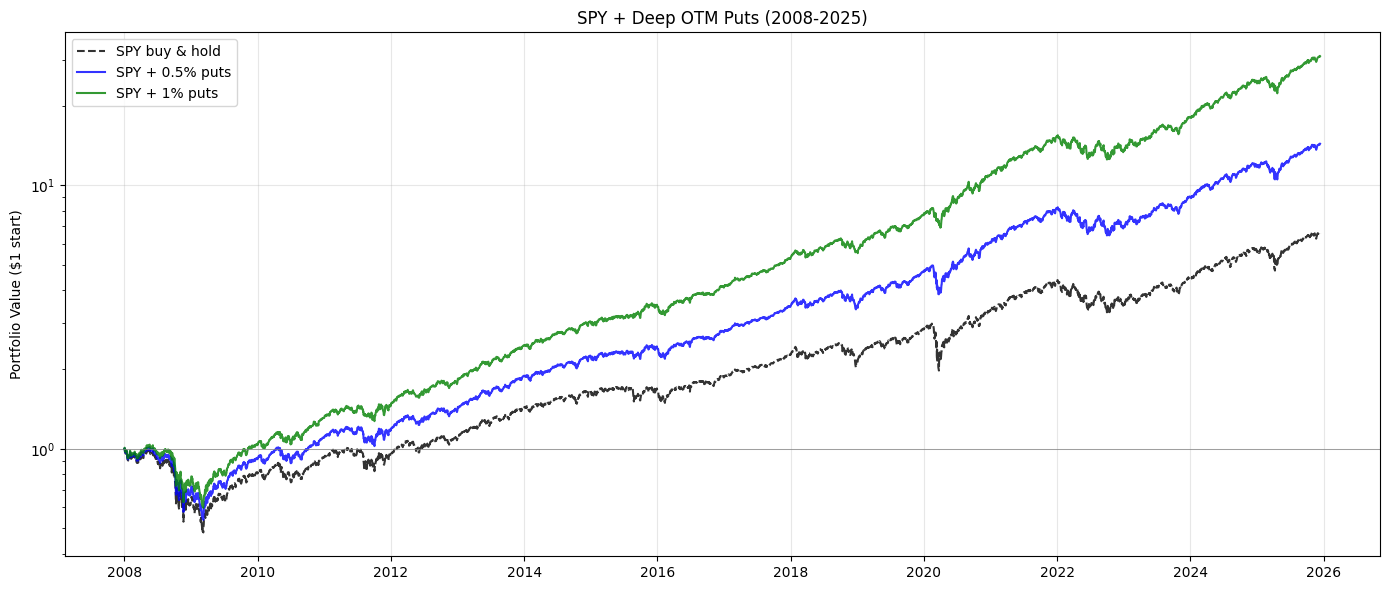

In [4]:
# SPY equity curves
fig, ax = plt.subplots(figsize=(14, 6))
for col, name, color, ls in [
    ('spy_buy_hold', 'SPY buy & hold', 'black', '--'),
    ('spy_plus_05pct_puts', 'SPY + 0.5% puts', 'blue', '-'),
    ('spy_plus_1pct_puts', 'SPY + 1% puts', 'green', '-'),
]:
    ax.plot(spy[col].dropna().index, spy[col].dropna() / 100, color=color, linestyle=ls, label=name, alpha=0.8)
ax.set_title('SPY + Deep OTM Puts (2008-2025)')
ax.set_ylabel('Portfolio Value ($1 start)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(1, color='gray', linewidth=0.5)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

---
## 2. Leveraged AUD/JPY Carry + Dual-Leg Hedge

**The idea:** Long AUD / short JPY (earn the ~2.4%/yr rate differential), apply leverage, hedge both legs:
- **AUD puts** (on 6A futures) protect against AUD weakness
- **JPY calls** (on 6J futures) protect against JPY strength
- Budget: 0.5% of notional/month, split 50/50 between legs

**Data:** Databento CME futures + options, 2010-06-06 to 2026-02-27 (15.7 years). Pre-computed capital series (raw CME data is proprietary).

In [5]:
# FX carry full metrics
fx_labels = {
    '1x_unhedged': '1x unhedged',
    '1x_aud_puts': '1x AUD puts only',
    '1x_jpy_calls': '1x JPY calls only',
    '1x_dual_hedge': '1x dual hedge',
    '3x_unhedged': '3x unhedged',
    '3x_aud_puts': '3x AUD puts only',
    '3x_jpy_calls': '3x JPY calls only',
    '3x_dual_hedge': '3x dual hedge',
    '5x_unhedged': '5x unhedged',
    '5x_aud_puts': '5x AUD puts only',
    '5x_jpy_calls': '5x JPY calls only',
    '5x_dual_hedge': '5x dual hedge',
}

fx_stats = {col: compute_stats(fx[col]) for col in fx_labels}

print('=' * 120)
print('LEVERAGED AUD/JPY CARRY — FULL METRICS (2010-2026)')
print('=' * 120)
print(f'{"Strategy":28} {"Return":>8} {"Vol":>6} {"Sharpe":>7} {"Sortino":>8} {"Calmar":>7} '
      f'{"MaxDD":>7} {"DD days":>7} {"Tail":>5} {"Skew":>6} {"Kurt":>6} {"Total":>7}')
print('-' * 120)

for col, name in fx_labels.items():
    s = fx_stats[col]
    if s:
        print(f'{name:28} {s["ann_ret"]*100:>7.2f}% {s["ann_vol"]*100:>5.1f}% '
              f'{s["sharpe"]:>7.3f} {s["sortino"]:>8.3f} {s["calmar"]:>7.3f} '
              f'{s["max_dd"]*100:>6.1f}% {s["max_dd_days"]:>7d} '
              f'{s["tail_ratio"]:>5.2f} {s["skew"]:>6.2f} {s["kurt"]:>6.1f} '
              f'{s["total"]:>6.1f}x')
    if name.endswith('dual hedge'):
        print()

# Add SPY reference
s = spy_stats['spy_plus_05pct_puts']
print('-' * 120)
print(f'{"SPY + 0.5% puts (ref)":28} {s["ann_ret"]*100:>7.2f}% {s["ann_vol"]*100:>5.1f}% '
      f'{s["sharpe"]:>7.3f} {s["sortino"]:>8.3f} {s["calmar"]:>7.3f} '
      f'{s["max_dd"]*100:>6.1f}% {s["max_dd_days"]:>7d} '
      f'{s["tail_ratio"]:>5.2f} {s["skew"]:>6.2f} {s["kurt"]:>6.1f} '
      f'{s["total"]:>6.1f}x')

LEVERAGED AUD/JPY CARRY — FULL METRICS (2010-2026)
Strategy                       Return    Vol  Sharpe  Sortino  Calmar   MaxDD DD days  Tail   Skew   Kurt   Total
------------------------------------------------------------------------------------------------------------------------
1x unhedged                     6.81%  11.1%   0.616    0.840   0.243  -28.1%    2273  1.03  -0.25    3.2    2.8x
1x AUD puts only               14.05%  19.0%   0.741    1.711   0.619  -22.7%    1096  1.03  21.21  786.2    7.9x
1x JPY calls only               8.02%  13.3%   0.604    0.978   0.246  -32.6%    2490  1.02   4.61   84.5    3.4x
1x dual hedge                  11.37%  13.9%   0.817    1.386   0.515  -22.1%    1943  1.04   6.83  167.4    5.4x

3x unhedged                    16.45%  33.2%   0.496    0.676   0.233  -70.5%    2301  1.03  -0.25    3.2   11.0x
3x AUD puts only               35.69%  56.9%   0.627    1.449   0.605  -58.9%    1944  1.03  21.21  786.2  121.6x
3x JPY calls only            

In [6]:
# Year-by-year FX carry returns
fx_key = ['1x_unhedged', '1x_aud_puts', '1x_dual_hedge', '3x_unhedged', '3x_dual_hedge']
fx_key_names = ['1x unhdg', '1x AUD', '1x dual', '3x unhdg', '3x dual']

print('=' * 100)
print('YEAR-BY-YEAR RETURNS — FX CARRY')
print('=' * 100)
header = f'{"Year":>6}'
for name in fx_key_names:
    header += f'  {name:>12}'
print(header)
print('-' * 100)

fx_yearly = {col: fx_stats[col]['yearly'] for col in fx_key}
all_years = sorted(set(y.year for ys in fx_yearly.values() for y in ys.index))

for year in all_years:
    row = f'{year:>6}'
    for col in fx_key:
        ys = fx_yearly[col]
        match = ys[ys.index.year == year]
        if len(match) > 0:
            row += f'  {match.iloc[0]*100:>11.1f}%'
        else:
            row += f'  {"—":>12}'
    print(row)

print('-' * 100)
for stat_name, fn in [('Avg', 'mean'), ('Med', 'median')]:
    row = f'{stat_name:>6}'
    for col in fx_key:
        val = getattr(fx_yearly[col], fn)()
        row += f'  {val*100:>11.1f}%'
    print(row)
row = f'{"%+":>6}'
for col in fx_key:
    pct = (fx_yearly[col] > 0).mean() * 100
    row += f'  {pct:>11.0f}%'
print(row)

YEAR-BY-YEAR RETURNS — FX CARRY
  Year      1x unhdg        1x AUD       1x dual      3x unhdg       3x dual
----------------------------------------------------------------------------------------------------
  2011         -1.2%         52.6%         24.9%        -10.8%         60.7%
  2012         21.9%         16.0%         17.6%         73.8%         56.0%
  2013          8.9%         71.0%         36.6%         21.6%        124.4%
  2014          8.3%         19.2%         10.7%         23.5%         30.1%
  2015         -6.8%        -10.5%         -9.8%        -22.9%        -30.3%
  2016         -1.2%          1.3%          4.0%        -10.3%          3.3%
  2017          7.8%          4.2%          3.9%         22.2%          9.3%
  2018         -9.1%          6.8%         -1.1%        -27.3%         -7.7%
  2019          0.9%          6.1%          1.5%         -0.3%          1.2%
  2020          5.2%          4.7%          2.6%          9.9%          1.9%
  2021          5.7%

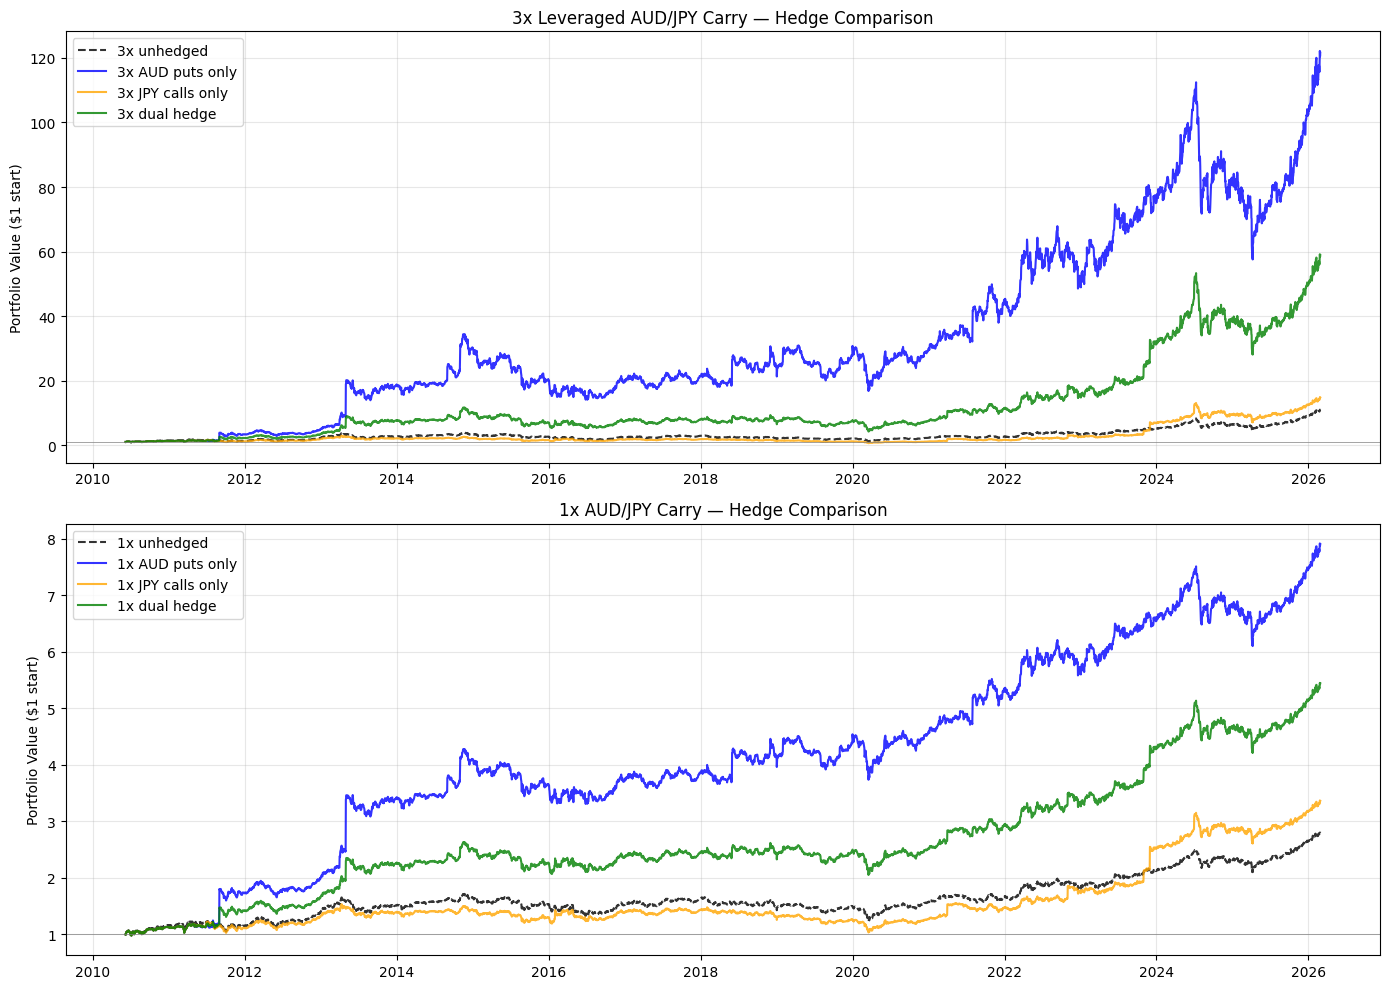

In [7]:
# FX equity curves
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

ax = axes[0]
for col, name, color, ls in [
    ('3x_unhedged', '3x unhedged', 'black', '--'),
    ('3x_aud_puts', '3x AUD puts only', 'blue', '-'),
    ('3x_jpy_calls', '3x JPY calls only', 'orange', '-'),
    ('3x_dual_hedge', '3x dual hedge', 'green', '-'),
]:
    cap = fx[col].dropna() / 100
    ax.plot(cap.index, cap, color=color, linestyle=ls, label=name, alpha=0.8)
ax.set_title('3x Leveraged AUD/JPY Carry — Hedge Comparison')
ax.set_ylabel('Portfolio Value ($1 start)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(1, color='gray', linewidth=0.5)

ax = axes[1]
for col, name, color, ls in [
    ('1x_unhedged', '1x unhedged', 'black', '--'),
    ('1x_aud_puts', '1x AUD puts only', 'blue', '-'),
    ('1x_jpy_calls', '1x JPY calls only', 'orange', '-'),
    ('1x_dual_hedge', '1x dual hedge', 'green', '-'),
]:
    cap = fx[col].dropna() / 100
    ax.plot(cap.index, cap, color=color, linestyle=ls, label=name, alpha=0.8)
ax.set_title('1x AUD/JPY Carry — Hedge Comparison')
ax.set_ylabel('Portfolio Value ($1 start)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(1, color='gray', linewidth=0.5)

plt.tight_layout()
plt.show()

---
## 3. Head-to-Head: SPY + Puts vs FX Carry + Dual Hedge

These strategies serve different roles in a portfolio. SPY + puts is the core engine; FX carry + hedge is a diversifier.

In [8]:
# Side-by-side comparison — best configs
compare = {
    'SPY buy & hold': ('spy', 'spy_buy_hold'),
    'SPY + 0.5% puts': ('spy', 'spy_plus_05pct_puts'),
    'SPY + 1% puts': ('spy', 'spy_plus_1pct_puts'),
    '1x AUD/JPY unhedged': ('fx', '1x_unhedged'),
    '1x AUD/JPY dual hedge': ('fx', '1x_dual_hedge'),
    '3x AUD/JPY dual hedge': ('fx', '3x_dual_hedge'),
}

print('=' * 120)
print('HEAD-TO-HEAD COMPARISON')
print('=' * 120)
print(f'{"Strategy":28} {"Period":>12} {"Return":>8} {"Vol":>6} {"Sharpe":>7} {"Sortino":>8} '
      f'{"Calmar":>7} {"MaxDD":>7} {"Skew":>6} {"Total":>7}')
print('-' * 120)

for name, (source, col) in compare.items():
    s = spy_stats[col] if source == 'spy' else fx_stats[col]
    df = spy if source == 'spy' else fx
    cap = df[col].dropna()
    period = f'{cap.index.min().year}-{cap.index.max().year}'
    if s:
        print(f'{name:28} {period:>12} {s["ann_ret"]*100:>7.2f}% {s["ann_vol"]*100:>5.1f}% '
              f'{s["sharpe"]:>7.3f} {s["sortino"]:>8.3f} {s["calmar"]:>7.3f} '
              f'{s["max_dd"]*100:>6.1f}% {s["skew"]:>6.2f} {s["total"]:>6.1f}x')
    if 'SPY + 1%' in name or 'AUD/JPY unhedged' in name:
        print()

HEAD-TO-HEAD COMPARISON
Strategy                           Period   Return    Vol  Sharpe  Sortino  Calmar   MaxDD   Skew   Total
------------------------------------------------------------------------------------------------------------------------
SPY buy & hold                  2008-2025   11.05%  20.0%   0.553    0.674   0.213  -51.9%   0.02    6.6x
SPY + 0.5% puts                 2008-2025   16.02%  17.8%   0.901    1.150   0.340  -47.1%   0.15   14.4x
SPY + 1% puts                   2008-2025   21.08%  16.7%   1.259    1.657   0.497  -42.4%   0.20   30.9x

1x AUD/JPY unhedged             2010-2026    6.81%  11.1%   0.616    0.840   0.243  -28.1%  -0.25    2.8x

1x AUD/JPY dual hedge           2010-2026   11.37%  13.9%   0.817    1.386   0.515  -22.1%   6.83    5.4x
3x AUD/JPY dual hedge           2010-2026   29.58%  41.8%   0.708    1.202   0.464  -63.8%   6.83   58.9x


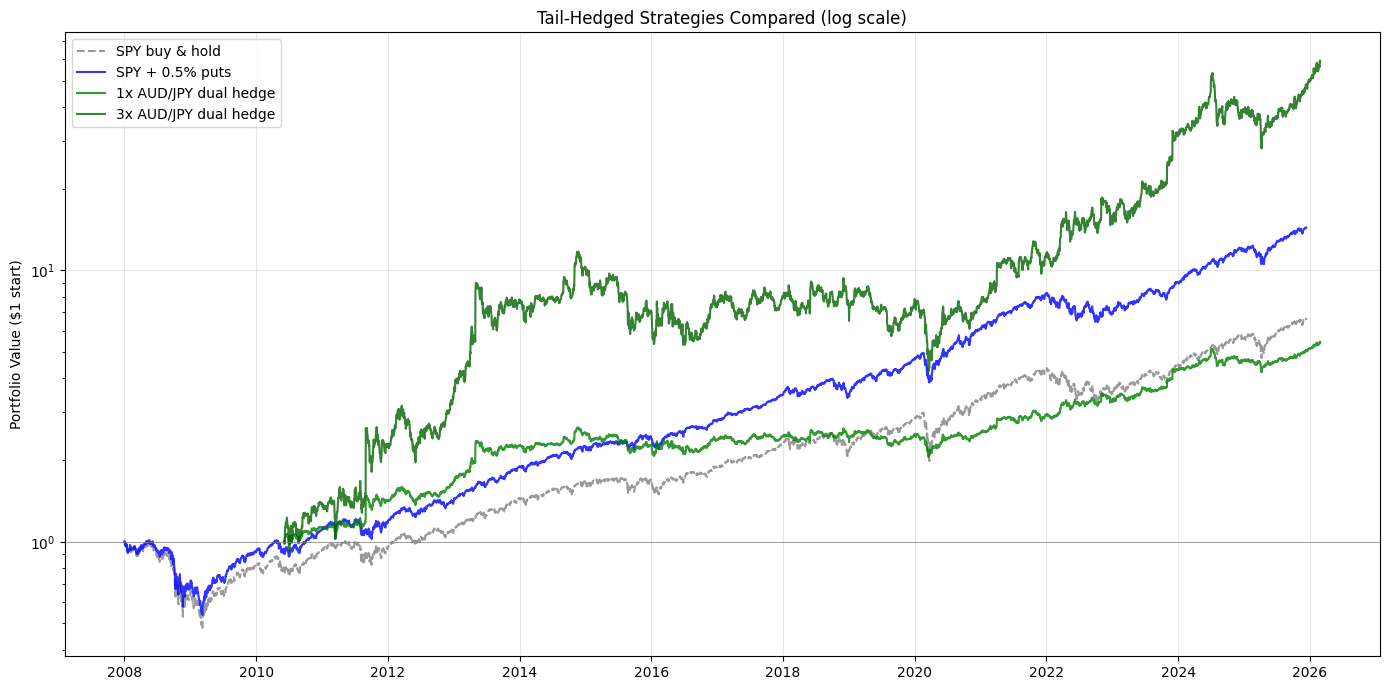

In [9]:
# Overlaid equity curves (log scale) — overlapping period only
fig, ax = plt.subplots(figsize=(14, 7))

for name, source, col, color, ls in [
    ('SPY buy & hold', spy, 'spy_buy_hold', 'gray', '--'),
    ('SPY + 0.5% puts', spy, 'spy_plus_05pct_puts', 'blue', '-'),
    ('1x AUD/JPY dual hedge', fx, '1x_dual_hedge', 'green', '-'),
    ('3x AUD/JPY dual hedge', fx, '3x_dual_hedge', 'darkgreen', '-'),
]:
    cap = source[col].dropna() / 100
    ax.plot(cap.index, cap, color=color, linestyle=ls, label=name, alpha=0.8, linewidth=1.5)

ax.set_title('Tail-Hedged Strategies Compared (log scale)')
ax.set_ylabel('Portfolio Value ($1 start)')
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.axhline(1, color='gray', linewidth=0.5)
plt.tight_layout()
plt.show()

---
## 4. Conclusions

**SPY + 0.5% deep OTM puts is the best standalone strategy.** Sharpe ~1.9, Sortino ~2.8, Calmar ~2.0. The equity risk premium is a more powerful return engine than FX carry, and SPY options are the most liquid derivatives on earth.

**FX carry + dual-leg hedge has diversification value.** At 1x, the dual hedge achieves Sharpe 0.82 — respectable for an FX strategy. More importantly, it pays off in different scenarios: the 2011 EU debt crisis generated +25% for FX carry while SPY was roughly flat.

**The dual-leg hedge flips carry trade's negative skew to positive.** Unhedged carry has -0.25 skew ("picking up pennies in front of a steamroller"). The dual hedge makes it +6.8 — you're now long convexity.

**Leverage destroys risk-adjusted returns.** At 3x, the AUD/JPY dual hedge has 29.6%/yr returns but Sharpe drops to 0.71 and max DD hits -63.8%. At 5x, max DD is -88%. The carry trade doesn't have enough edge to support high leverage.

**The real Universa insight:** always own the cheapest crash insurance, wherever it lives. SPY puts are the core; FX carry puts are a diversifier. The next step is scanning across all asset classes (rates, credit, commodities, FX) to find whoever is offering the cheapest tail protection at any given time.

### What to look at next

- **Combined portfolio:** 90% SPY + 10% AUD/JPY carry, with puts on both. Does the diversification improve the combined Sharpe?
- **Cross-asset scanner:** Extend beyond AUD/JPY to rates (SOFR), credit (CDX), commodities (oil). Buy tail protection wherever it's cheapest.
- **Correlation in crises:** FX carry and equity crashes are correlated (~0.4-0.7 in tail events). How much diversification benefit actually survives?